In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle
import joblib
import time
import kagglehub
import seaborn as sns

In [2]:
bigram_df = pd.read_csv("linkedin/bigram.csv")
t5_title_embedding_df = pd.read_csv("linkedin/t5_title_embedding.csv")
paraphrase_title_embedding_df = pd.read_csv("linkedin/paraphrase_title_embedding.csv")
t5_total_embedding_df = pd.read_csv("linkedin/t5_total_embedding.csv")
smoothed_unigram_df = pd.read_csv("linkedin/smoothed_unigram.csv")
paraphrase_total_embedding_df = pd.read_csv("linkedin/paraphrase_total_embedding.csv")
unigram_df = pd.read_csv("linkedin/unigram.csv")
tfidf_df = pd.read_csv("linkedin/tfidf.csv")
sbert_df = pd.read_csv("linkedin/sbert.csv")
doc2vec_df = pd.read_csv("linkedin/doc2vec.csv")

In [3]:
models = {
    "bigram": bigram_df,
    "t5_title_embedding": t5_title_embedding_df,
    "paraphrase_title_embedding": paraphrase_title_embedding_df,
    "t5_total_embedding": t5_total_embedding_df,
    "smoothed_unigram": smoothed_unigram_df,
    "paraphrase_total_embedding": paraphrase_total_embedding_df,
    "unigram": unigram_df,
    "tfidf": tfidf_df,
    "sbert": sbert_df,
    "doc2vec": doc2vec_df
}

# Dataset analysis

In [4]:
path = kagglehub.dataset_download("arshkon/linkedin-job-postings")
raw_df = pd.read_csv(os.path.join(path,"postings.csv"))

In [5]:
raw_df = raw_df[['title', 'description', 'max_salary', 'min_salary', 'location']]
raw_df

,title,description,max_salary,min_salary,location
0,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,17.0,"Princeton, NJ"
1,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,30.0,"Fort Collins, CO"
2,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,45000.0,"Cincinnati, OH"
3,Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,140000.0,"New Hyde Park, NY"
4,Service Technician,Looking for HVAC service tech with experience ...,80000.0,60000.0,"Burlington, IA"
...,...,...,...,...,...
123844,Title IX/Investigations Attorney,Our Walnut Creek office is currently seeking a...,195000.0,120000.0,"Walnut Creek, CA"
123845,"Staff Software Engineer, ML Serving Platform",About Pinterest:\n\nMillions of people across ...,NaN,NaN,United States
123846,"Account Executive, Oregon/Washington",Company Overview\n\nEPS Learning is a leading ...,NaN,NaN,"Spokane, WA"
123847,Business Development Manager,The Business Development Manager is a 'hunter'...,NaN,NaN,"Texas, United States"


## Salary distribution

In [6]:
raw_df['max_salary'] = pd.to_numeric(raw_df['max_salary'], errors='coerce')
raw_df = raw_df.dropna(subset=['max_salary'])

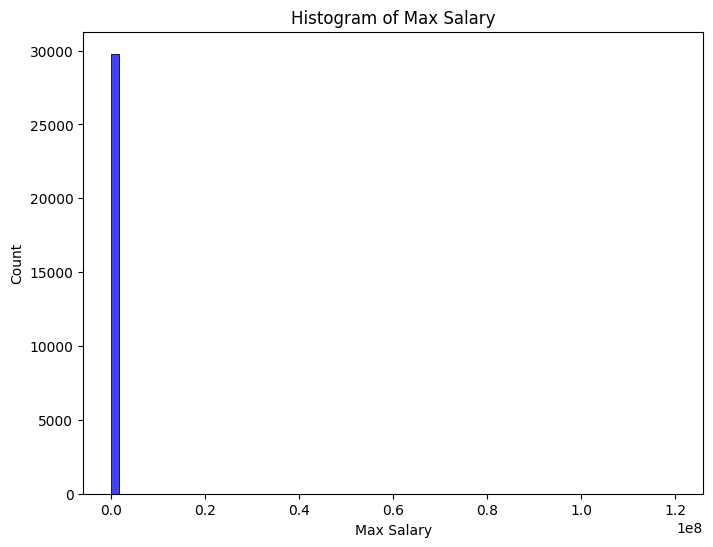

In [7]:
plt.figure(figsize=(8, 6))
sns.histplot(data=raw_df, x='max_salary', bins=70, kde=False, color='blue')
plt.title("Histogram of Max Salary")
plt.xlabel("Max Salary")
plt.ylabel("Count")
plt.show()

In [8]:
counts, bin_edges = np.histogram(raw_df['max_salary'], bins=70)

for i in range(len(counts)):
    print(f"Bin range: {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}, Count: {counts[i]}")

Bin range: 1.00 - 1714286.70, Count: 29792
Bin range: 1714286.70 - 3428572.40, Count: 0
Bin range: 3428572.40 - 5142858.10, Count: 0
Bin range: 5142858.10 - 6857143.80, Count: 0
Bin range: 6857143.80 - 8571429.50, Count: 0
Bin range: 8571429.50 - 10285715.20, Count: 0
Bin range: 10285715.20 - 12000000.90, Count: 0
Bin range: 12000000.90 - 13714286.60, Count: 0
Bin range: 13714286.60 - 15428572.30, Count: 0
Bin range: 15428572.30 - 17142858.00, Count: 0
Bin range: 17142858.00 - 18857143.70, Count: 0
Bin range: 18857143.70 - 20571429.40, Count: 0
Bin range: 20571429.40 - 22285715.10, Count: 0
Bin range: 22285715.10 - 24000000.80, Count: 0
Bin range: 24000000.80 - 25714286.50, Count: 0
Bin range: 25714286.50 - 27428572.20, Count: 0
Bin range: 27428572.20 - 29142857.90, Count: 0
Bin range: 29142857.90 - 30857143.60, Count: 0
Bin range: 30857143.60 - 32571429.30, Count: 0
Bin range: 32571429.30 - 34285715.00, Count: 0
Bin range: 34285715.00 - 36000000.70, Count: 0
Bin range: 36000000.70 - 3

In [9]:
raw_df['max_salary'].describe()

count    2.979300e+04
mean     9.193942e+04
std      7.011101e+05
min      1.000000e+00
25%      4.828000e+01
50%      8.000000e+04
75%      1.400000e+05
max      1.200000e+08
Name: max_salary, dtype: float64

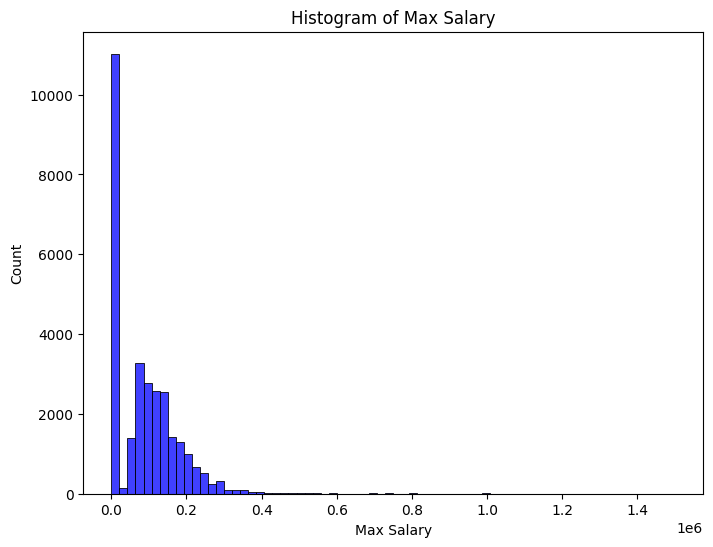

In [10]:
# Remove rows where max_salary is greater than 1,000,000
filtered_raw_df = raw_df[raw_df['max_salary'] <= 1_800_000]

plt.figure(figsize=(8, 6))
sns.histplot(data=filtered_raw_df, x='max_salary', bins=70, kde=False, color='blue')
plt.title("Histogram of Max Salary")
plt.xlabel("Max Salary")
plt.ylabel("Count")
plt.show()

In [11]:
counts, bin_edges = np.histogram(filtered_raw_df['max_salary'], bins=70)

for i in range(len(counts)):
    print(f"Bin range: {bin_edges[i]:.2f} - {bin_edges[i+1]:.2f}, Count: {counts[i]}")

Bin range: 1.00 - 21429.56, Count: 11024
Bin range: 21429.56 - 42858.11, Count: 151
Bin range: 42858.11 - 64286.67, Count: 1387
Bin range: 64286.67 - 85715.23, Count: 3263
Bin range: 85715.23 - 107143.79, Count: 2770
Bin range: 107143.79 - 128572.34, Count: 2582
Bin range: 128572.34 - 150000.90, Count: 2556
Bin range: 150000.90 - 171429.46, Count: 1429
Bin range: 171429.46 - 192858.01, Count: 1302
Bin range: 192858.01 - 214286.57, Count: 998
Bin range: 214286.57 - 235715.13, Count: 674
Bin range: 235715.13 - 257143.69, Count: 529
Bin range: 257143.69 - 278572.24, Count: 248
Bin range: 278572.24 - 300000.80, Count: 317
Bin range: 300000.80 - 321429.36, Count: 105
Bin range: 321429.36 - 342857.91, Count: 86
Bin range: 342857.91 - 364286.47, Count: 93
Bin range: 364286.47 - 385715.03, Count: 32
Bin range: 385715.03 - 407143.59, Count: 49
Bin range: 407143.59 - 428572.14, Count: 25
Bin range: 428572.14 - 450000.70, Count: 22
Bin range: 450000.70 - 471429.26, Count: 8
Bin range: 471429.26 -

In [12]:
filtered_raw_df['max_salary'].describe()

count    2.979200e+04
mean     8.791458e+04
std      9.449158e+04
min      1.000000e+00
25%      4.827000e+01
50%      8.000000e+04
75%      1.400000e+05
max      1.500000e+06
Name: max_salary, dtype: float64

# Prediction analysis

In [13]:
def accuracy_within_tolerance(y_true, y_pred, tolerance=0.20):
    """
    Calculates the percentage of predictions within the given percentage tolerance range.
    
    Args:
    - y_true (array-like): Ground truth values.
    - y_pred (array-like): Predicted values.
    - tolerance (float): Tolerance as a percentage (e.g., 0.20 for 20%).
    
    Returns:
    - accuracy (float): Percentage (e.g., 0.20 for 20%) of accurate predictions within tolerance.
    """

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Absolute percentage error
    percentage_error = np.abs(y_true - y_pred) / y_true
    
    # Predictions within tolerance
    within_tolerance = np.sum(percentage_error <= tolerance)
    
    # Accuracy 
    accuracy = within_tolerance / len(y_true)
    return accuracy

In [14]:
# labels_df = pd.read_csv("../linkedin_salary_targets.csv")
labels_df = raw_df[raw_df["max_salary"].notna() & raw_df["min_salary"].notna() & raw_df["description"].notna()]

In [ ]:
# import xgboost as xg 

def train_and_score_gbt(X, y, model_name, dataset_name="linkedin"):
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    # 2. Train GBT Model
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
    # clf = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = 100, max_depth=5, seed = 0, learning_rate=1.0)
    clf.fit(X_train,y_train)

    # 3. Get Predictions and Residuals
    y_pred = clf.predict(X_test)
    residuals = y_test - y_pred

    # 4. Score
    scores = {
        'model_name': model_name,
        'r2': r2_score(y_pred, y_test),
        'mae': mean_absolute_error(y_pred, y_test),
        'rmse': root_mean_squared_error(y_pred, y_test)
    }
    
    # 5. Accuracy within tolerance
    tolerance_acc = {
        'tolerance': [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7],
        'accuracy': []
    }
    tolerance_acc['tolerance_str'] = [f"{acc * 100:.0f}%" for acc in tolerance_acc['tolerance']]

    for tol in tolerance_acc['tolerance']:
        acc = accuracy_within_tolerance(y_test, y_pred, tolerance=tol)
        tolerance_acc['accuracy'].append(acc)

    return scores, tolerance_acc

In [16]:
model_tolerance_acc = { }
tolerance_str_list = []

scores_df = pd.DataFrame(columns=['model_name','r2','mae','rmse'])

for (model_name, features_df) in models.items():
    t0 = time.time()

    scores, tolerance_acc = train_and_score_gbt(
        X=features_df.to_numpy(), 
        y=labels_df.max_salary.to_numpy(),
        model_name=model_name
    )
    scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)
    t1 = time.time()
    total = t1-t0
    print(f"Finished {model_name} in {total} seconds.")
    # print(scores_df.head())
    model_tolerance_acc[model_name] = tolerance_acc
    tolerance_str_list = tolerance_acc['tolerance_str']

/var/folders/v2/xp28m4jj3z7fyzyg9t6k4vhh0000gn/T/ipykernel_87618/1370277072.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)


Finished bigram in 1.0566718578338623 seconds.
Finished t5_title_embedding in 2.6091301441192627 seconds.
Finished paraphrase_title_embedding in 1.5319678783416748 seconds.
Finished t5_total_embedding in 2.827641010284424 seconds.
Finished smoothed_unigram in 0.9862205982208252 seconds.
Finished paraphrase_total_embedding in 1.4501419067382812 seconds.
Finished unigram in 1.0295100212097168 seconds.
Finished tfidf in 4.126680850982666 seconds.
Finished sbert in 1.5253069400787354 seconds.
Finished doc2vec in 0.5769948959350586 seconds.


## Tolerance & Error

In [17]:
acc_tol_df = pd.DataFrame(columns=['model'] + tolerance_str_list)

for _model in model_tolerance_acc:
    row = [_model] + model_tolerance_acc[_model]['accuracy']
    acc_tol_df.loc[len(acc_tol_df)] = row

In [18]:
acc_tol_df = acc_tol_df.set_index('model')
acc_tol_df

,5%,10%,20%,30%,40%,50%,60%,70%
model,,,,,,,,
bigram,0.060016,0.120704,0.217240,0.309613,0.380908,0.438238,0.485365,0.522154
t5_title_embedding,0.058136,0.112782,0.203813,0.286251,0.351235,0.404270,0.454887,0.492347
paraphrase_title_embedding,0.052900,0.109828,0.203276,0.278733,0.344119,0.398496,0.449248,0.486842
t5_total_embedding,0.049141,0.093448,0.175752,0.253088,0.321966,0.378759,0.431525,0.474624
smoothed_unigram,0.058673,0.115467,0.221670,0.307599,0.376074,0.438776,0.488050,0.522422
paraphrase_total_embedding,0.047261,0.091702,0.175349,0.246778,0.311762,0.368287,0.418367,0.463212
unigram,0.062701,0.118690,0.218448,0.303571,0.380773,0.439715,0.489930,0.529135
tfidf,0.057734,0.119227,0.223281,0.314581,0.388561,0.442535,0.488319,0.531015
sbert,0.047395,0.089151,0.174006,0.248657,0.310016,0.366944,0.420918,0.460526


## Scores for R2, MAE, RMSE

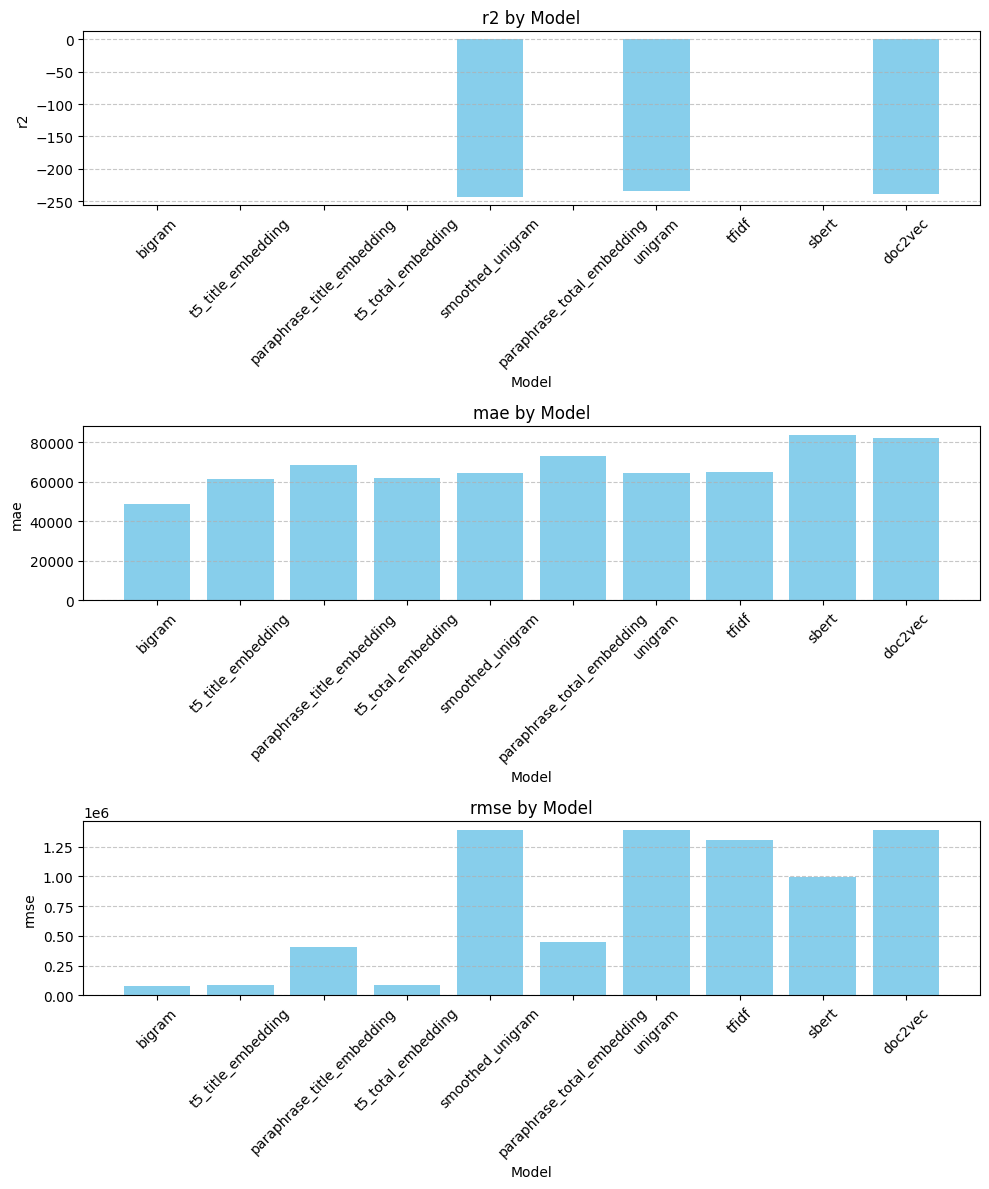

In [ ]:
models = scores_df["model_name"]
scores = scores_df.iloc[:, 1:]  # All score columns
score_columns = scores.columns

# Bar width and positions
bar_width = 0.2
x = np.arange(len(models))  # Position of models on x-axis

plt.figure(figsize=(10, 12))

for i, (score_name, score_values) in enumerate(scores.items(), start=1):
    plt.subplot(3, 1, i)  # Create a subplot for each score
    plt.bar(models, score_values, color="skyblue")
    plt.title(f"{score_name} by Model")
    plt.xlabel("Model")
    plt.ylabel(score_name)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
# Adjust layout
plt.tight_layout()
plt.show()